In [1]:
import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

import torch
import torch.nn as nn
from torch import Tensor

import torchvision.models as models
from torchvision import transforms
from torchvision.models.utils import load_state_dict_from_url

from typing import Type, Any, Callable, Union, List, Dict, Optional, cast
from collections import OrderedDict 

In [2]:
from torchvision.models.resnet import *
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls

In [3]:
from os import listdir
from os.path import isfile, join
images_list = [join("C:\\Users\\Mortada\\Python\\Image_retrieval\\mine\\data\\jpg\\", f) for f in listdir("C:\\Users\\Mortada\\Python\\Image_retrieval\\mine\\data\\jpg") if isfile(join("C:\\Users\\Mortada\\Python\\Image_retrieval\\mine\\data\\jpg\\", f))]

In [142]:
resnet18 = models.resnet50()
#inception = models.inception_v3(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
class IntResNet(ResNet):
    def __init__(self,output_layer,*args):
        self.output_layer = output_layer
        super().__init__(*args)
        
        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [6]:
def new_resnet(
    arch: str,
    outlayer: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> IntResNet:

    model_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
        'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
        'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
        'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
        'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
    }

    model = IntResNet(outlayer, block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [144]:
model = new_resnet('resnet50','avgpool',Bottleneck, [3,4,6,3],True,True)
model = model.to('cuda:0')

In [145]:
from torchsummary import summary
summary(model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000000.jpg


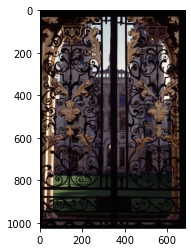

(2048,)
(2048,)


In [146]:
print(images_list[0])
imgplot = plt.imshow(mpimg.imread(images_list[0]))
plt.show()

input_image = Image.open(images_list[0])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    
out = model(input_batch)
out = out.cpu().data.numpy()

output = np.squeeze(out).ravel()
print(output.shape)
z = output.ravel()
print(z.shape)

In [12]:
class NewModel(nn.Module):
    # base_model : The model we want to get the output from
    # base_out_layer : The layer we want to get output from
    # num_trainable_layer : Number of layers we want to finetune (counted from the top)
    #                       if enetered value is -1, then all the layers are fine-tuned
    def __init__(self,base_model,base_out_layer,num_trainable_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer
        self.num_trainable_layers = num_trainable_layers
        
        self.model_dict = {'resnet18':{'block':BasicBlock,'layers':[2,2,2,2],'kwargs':{}},
                           'resnet34':{'block':BasicBlock,'layers':[3,4,6,3],'kwargs':{}},
                           'resnet50':{'block':Bottleneck,'layers':[3,4,6,3],'kwargs':{}},
                           'resnet101':{'block':Bottleneck,'layers':[3,4,23,3],'kwargs':{}},
                           'resnet152':{'block':Bottleneck,'layers':[3,8,36,3],'kwargs':{}},
                           'resnext50_32x4d':{'block':Bottleneck,'layers':[3,4,6,3],
                                              'kwargs':{'groups' : 32,'width_per_group' : 4}},
                           'resnext101_32x8d':{'block':Bottleneck,'layers':[3,4,23,3],
                                               'kwargs':{'groups' : 32,'width_per_group' : 8}},
                           'wide_resnet50_2':{'block':Bottleneck,'layers':[3,4,6,3],
                                              'kwargs':{'width_per_group' : 64 * 2}},
                           'wide_resnet101_2':{'block':Bottleneck,'layers':[3,4,23,3],
                                               'kwargs':{'width_per_group' : 64 * 2}}}
        
        #PRETRAINED MODEL
        self.resnet = self.new_resnet(self.base_model,self.base_out_layer,
                                     self.model_dict[self.base_model]['block'],
                                     self.model_dict[self.base_model]['layers'],
                                     True,True,
                                     **self.model_dict[self.base_model]['kwargs'])

        self.layers = list(self.resnet._modules.keys())
        #FREEZING LAYERS
        self.total_children = 0
        self.children_counter = 0
        for c in self.resnet.children():
            self.total_children += 1
            
        if self.num_trainable_layers == -1:
            self.num_trainable_layer = self.total_children
        
        for c in self.resnet.children():
            if self.children_counter < self.total_children - self.num_trainable_layers:
                for param in c.parameters():
                    param.requires_grad = False
            else:
                for param in c.parameters():
                    param.requires_grad =True
            self.children_counter += 1
                    
    def new_resnet(self,
                   arch: str,
                   outlayer: str,
                   block: Type[Union[BasicBlock, Bottleneck]],
                   layers: List[int],
                   pretrained: bool,
                   progress: bool,
                   **kwargs: Any
                  ) -> IntResNet:

        '''model_urls = {
            'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
            'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
            'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
            'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
            'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
            'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
            'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
            'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
            'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
        }'''

        model = IntResNet(outlayer, block, layers, **kwargs)
        if pretrained:
            state_dict = load_state_dict_from_url(model_urls[arch],
                                                  progress=progress)
            model.load_state_dict(state_dict)
        return model
    
    def forward(self,x):
        x = self.resnet(x)
        return x

In [7]:
my_model = nn.Sequential(*list(resnet18.children())[:-2])
#resnet18.avgpool = Identity()
print(my_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [147]:
import sys
image_features = []
i = 0
for image in images_list:
#for image in range(1):
    #input_image = Image.open(images_list[i])
    input_image = Image.open(image)
    i += 1
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    out = model(input_batch)
    out = out.cpu().data.numpy()
    output = np.squeeze(out).ravel()
    
    #with torch.no_grad():
        #output = my_model(input_batch)

    #print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    #probabilities = torch.nn.functional.softmax(output[0], dim=0)
    image_features.append(output)
    
    sys.stdout.write("\r{0} done out of 5063".format(i))
    sys.stdout.flush()
    
print("\n")
a = np.array(image_features)
print(a.shape)


5063 done out of 5063

(5063, 2048)


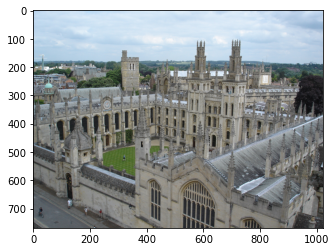

In [226]:
image_path = images_list[49]
imgplot = plt.imshow(mpimg.imread(image_path))
plt.show()

In [227]:
input_image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

out = model(input_batch)
out = out.cpu().data.numpy()
query = np.squeeze(out).ravel()
query.shape

(2048,)

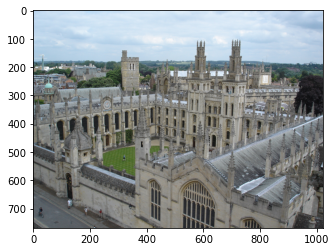

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000066.jpg


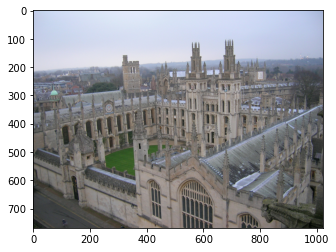

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000087.jpg


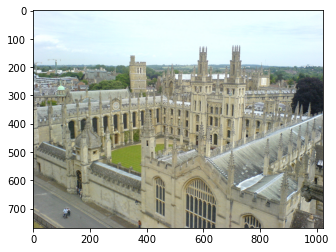

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oxford_003315.jpg


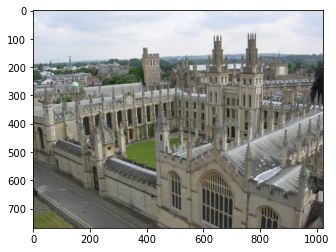

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oriel_000072.jpg


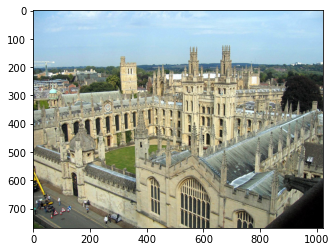

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oxford_000962.jpg


In [230]:
dist_vec = np.linalg.norm(a - query, axis=1)
ranked = np.argsort(dist_vec)
closest = ranked[:5]

for i in closest:
    imgplot = plt.imshow(mpimg.imread(images_list[i]))
    plt.show()
    print(images_list[i])

In [248]:
a = np.array(image_features)
index = [0] * 5063
for i in range(2048):
    b = a[:,i]
    
    dist_vec = [0] * 5063
    for j in range(5063):
        dist_vec[j] = abs(b[j] - query[i])
    #dist_vec[:] = [number - query[i] for number in b]
    ranked = np.argsort(dist_vec)
    closest = ranked[:10]
    for j in closest:
        index[j] += 1
        
index

[6,
 5,
 3,
 7,
 7,
 4,
 1,
 7,
 6,
 3,
 0,
 3,
 7,
 4,
 3,
 3,
 6,
 7,
 4,
 3,
 4,
 2,
 4,
 2,
 3,
 4,
 4,
 6,
 5,
 2,
 2,
 3,
 7,
 1,
 4,
 7,
 4,
 4,
 3,
 2,
 4,
 4,
 3,
 3,
 4,
 5,
 8,
 3,
 4,
 2048,
 4,
 4,
 6,
 3,
 6,
 3,
 1,
 2,
 6,
 8,
 5,
 2,
 3,
 2,
 7,
 4,
 4,
 2,
 6,
 4,
 3,
 5,
 7,
 5,
 5,
 5,
 7,
 5,
 1,
 7,
 4,
 1,
 4,
 2,
 6,
 4,
 3,
 5,
 2,
 4,
 5,
 3,
 2,
 5,
 12,
 5,
 2,
 5,
 2,
 2,
 4,
 4,
 3,
 5,
 3,
 2,
 2,
 5,
 4,
 2,
 4,
 5,
 6,
 6,
 2,
 3,
 4,
 6,
 7,
 1,
 5,
 5,
 2,
 5,
 4,
 7,
 3,
 9,
 5,
 3,
 5,
 6,
 2,
 3,
 6,
 5,
 1,
 2,
 7,
 1,
 3,
 6,
 2,
 4,
 3,
 4,
 6,
 3,
 6,
 6,
 3,
 5,
 4,
 5,
 4,
 3,
 2,
 5,
 2,
 0,
 5,
 2,
 4,
 0,
 4,
 4,
 4,
 3,
 3,
 2,
 4,
 4,
 4,
 1,
 5,
 2,
 3,
 6,
 4,
 2,
 5,
 2,
 1,
 4,
 1,
 5,
 6,
 4,
 1,
 2,
 3,
 4,
 4,
 6,
 5,
 3,
 4,
 5,
 2,
 1,
 8,
 7,
 5,
 3,
 4,
 2,
 6,
 0,
 4,
 1,
 6,
 2,
 5,
 6,
 5,
 3,
 6,
 7,
 5,
 3,
 4,
 4,
 6,
 2,
 3,
 8,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 3,
 8,
 2,
 6,
 4,
 3,
 6,
 3,
 3,
 7,
 1,
 2,
 3,
 2,
 4,
 1,


In [251]:
a = np.array(image_features)
index = [0] * 5063
for i in range(2048):
    dist_vec = [0] * 5063
    for j in range(5063):
        d = [0] * 2048
        for k in range(2048):
            d[k] = abs(a[j,k] - query[i])
        dist_vec[j] = np.argmax(d)
    #dist_vec[:] = [number - query[i] for number in b]
    ranked = np.argsort(dist_vec)
    closest = ranked[:10]
    for j in closest:
        index[j] += 1
        
index

KeyboardInterrupt: 

49


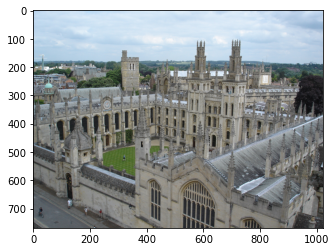

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000066.jpg


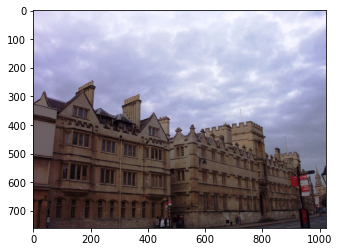

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oxford_000236.jpg


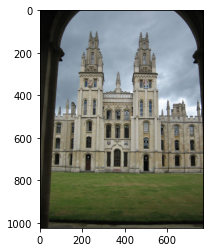

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000150.jpg


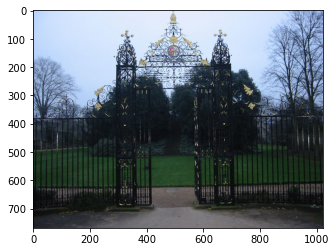

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\new_000961.jpg


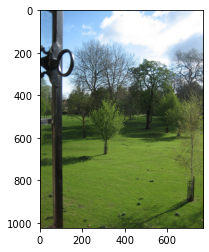

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\magdalen_000481.jpg


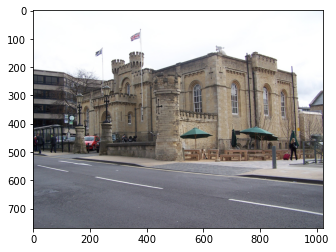

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oxford_001658.jpg


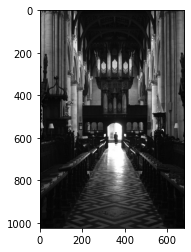

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\jesus_000040.jpg


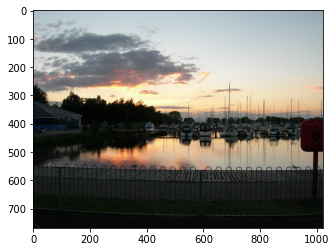

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\oxford_000930.jpg


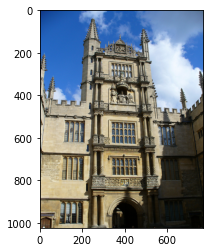

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\bodleian_000385.jpg


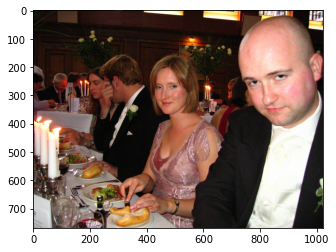

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\jesus_000287.jpg


In [249]:
indeces = np.array(index)
print(np.argmax(indeces))
ranked = indeces.argsort()[::-1][:10]

for i in ranked:
    imgplot = plt.imshow(mpimg.imread(images_list[i]))
    plt.show()
    print(images_list[i])

In [253]:
from sklearn.cluster import DBSCAN
#clustering = MeanShift().fit_predict(vecs.T)
#print(np.unique(clustering))

dbscan_clustering = DBSCAN().fit(a.T)
print(dbscan_clustering.labels_.tolist())

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [257]:
from sklearn.cluster import MeanShift
a = np.array(image_features).T
b = a[:100]
print(b.shape)
clustering = MeanShift().fit_predict(a)
print(np.unique(clustering).shape)

(100, 5063)
(7,)


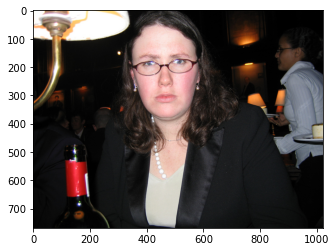

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\balliol_000078.jpg


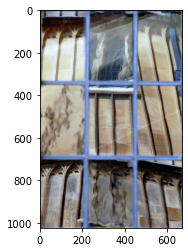

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\bodleian_000191.jpg


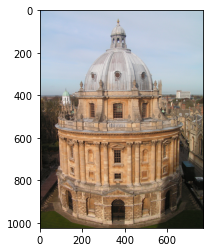

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\bodleian_000410.jpg


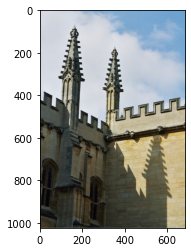

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\bodleian_000411.jpg


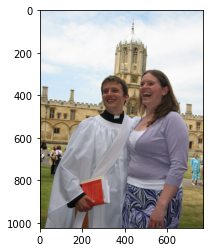

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\christ_church_000856.jpg


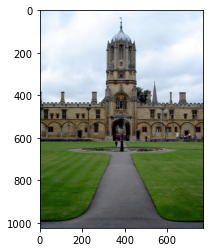

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\christ_church_001033.jpg


In [265]:
for i in np.where(clustering==2)[0]:
    imgplot = plt.imshow(mpimg.imread(images_list[i]))
    plt.show()
    print(images_list[i])

In [1]:
import pickle
infile = open("C:\\Users\\Mortada\\Python\\Image_retrieval\\mine\\data\\gnd_oxford5k.pkl",'rb')
new_dict = pickle.load(infile)
infile.close()

In [44]:
databas_dir = "C:\\Users\\Mortada\\Python\\Image_retrieval\\mine\\data\\jpg\\"
images_list = new_dict["imlist"]
databas_dir + images_list[0]

dict

In [38]:
for i in range(len(new_dict["qidx"])):
    query = new_dict["imlist"][new_dict["qidx"][i]]
    bbx = new_dict["gnd"][i]["bbx"]
    ok = new_dict["gnd"][i]["ok"]
    junk = new_dict["gnd"][i]["junk"]
    print(len(junk))

0
33
1
33


In [ ]:
all_souls_000220
all_souls_000019
all_souls_000017
oxford_000135
all_souls_000062
oxford_000546
all_souls_000145
all_souls_000000
all_souls_000188
oxford_002762
all_souls_000202
all_souls_000059
oxford_002508
all_souls_000176
all_souls_000053
all_souls_000045
all_souls_000054
all_souls_000167
all_souls_000085
all_souls_000110
oxford_000587
all_souls_000186
all_souls_000057
all_souls_000206
all_souls_000107
all_souls_000205
all_souls_000060
all_souls_000180
oxford_000542
bodleian_000367
bodleian_000134
all_souls_000174
all_souls_000005

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000000.jpg


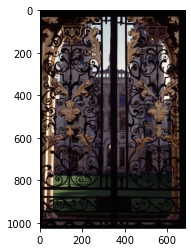

1
Layer  1


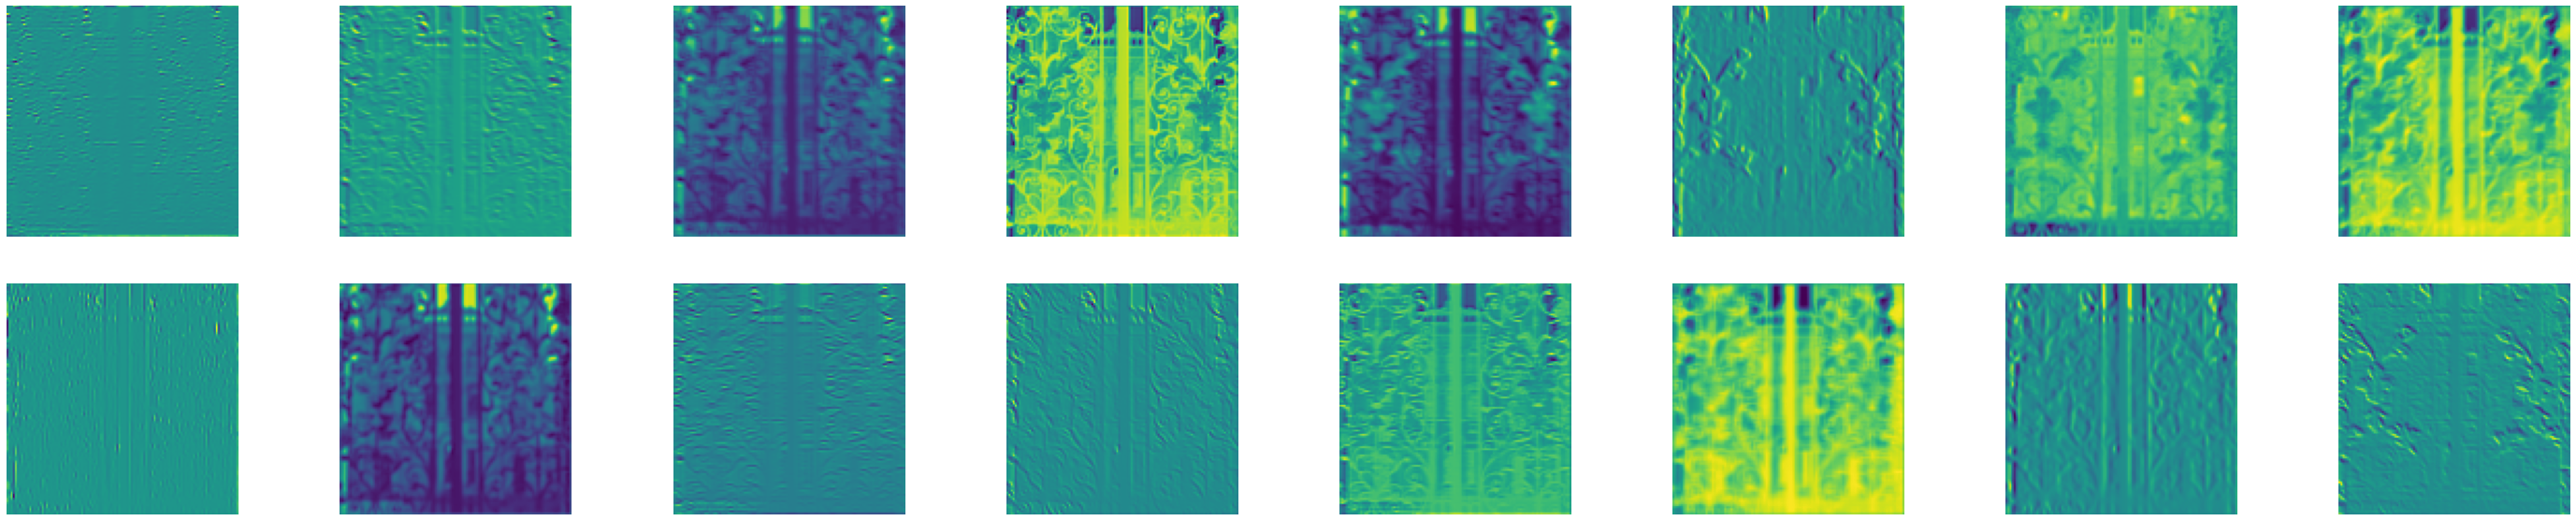

In [43]:
print(images_list[0])
imgplot = plt.imshow(mpimg.imread(images_list[0]))
plt.show()

input_image = Image.open(images_list[0])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet18.to('cuda')

no_of_layers=0
conv_layers=[]
 
model_children=list(resnet18.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

results = [conv_layers[0](input_batch)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu())
        plt.axis("off")
    plt.show()
    plt.close()

C:\Users\Mortada\Python\Image_retrieval\mine\data\jpg\all_souls_000002.jpg


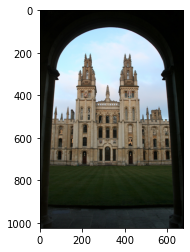

Layer  1


ValueError: num must be 1 <= num <= 16, not 17

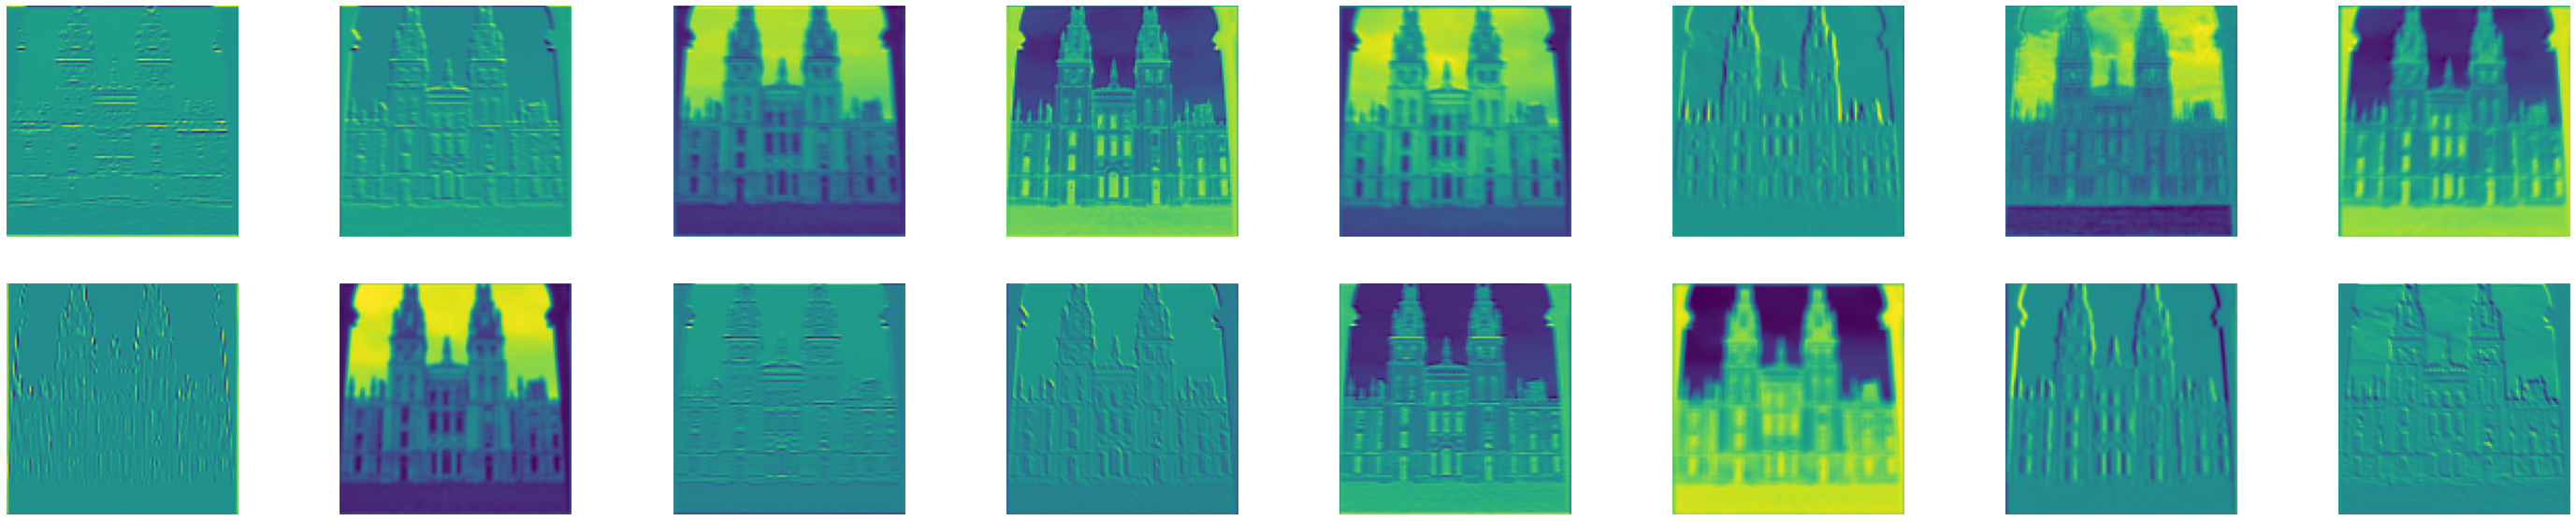

In [8]:
image = images_list[2]
print(image)
imgplot = plt.imshow(mpimg.imread(image))
plt.show()

input_image = Image.open(image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    my_model.to('cuda')

model_children=list(my_model.children())

results = [model_children[0](input_batch)]
for i in range(1, len(model_children)):
    results.append(model_children[i](results[-1]))
    
    for num_layer in range(len(results)):
        plt.figure(figsize=(50, 10))
        layer_viz = results[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            plt.subplot(2, 8, i + 1)
            plt.imshow(filter.cpu())
            plt.axis("off")
        plt.show()
        plt.close()

In [41]:
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
object_methods = [method_name for method_name in dir(resnet18)
                  if callable(getattr(resnet18, method_name))]

object_methods

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_apply',
 '_call_impl',
 '_forward_impl',
 '_get_backward_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_norm_layer',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 'add_module',
 'apply',
 'avgpool',
 'bfloat16',
 'bn1',
 'buffers',
 'children',
 'conv1',
 'cpu',
 'cuda',
 'double',
 'eval',
 'extra_repr',
 'fc',
 'float',
 'forward',
 'half',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'load_state_dict',
 'maxpool',
 'modules',
 'named_buffers',
 'named_c

In [16]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.
